# finger printing using numpy and scipy for numerical calculations, matplotlib to graph

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from matplotlib.mlab import specgram
from scipy.io import wavfile
from scipy import signal
from skimage.feature import peak_local_max

In [107]:
import pyaudio
import wave

Begin by recording from the microphone with 44.1KHz sampling rate into a 16 bit audio signal in 1024 bit chunks

In [110]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 48000
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = "pyaudio_recording.wav"

In [111]:
p = pyaudio.PyAudio()

stream = p.open(format = FORMAT, 
               channels= CHANNELS,
               rate = RATE,
               input = True,
               frames_per_buffer = CHUNK)
print("recording stream")
frames = []
for i in range(0,int(RATE/CHUNK*RECORD_SECONDS)):
    data = stream.read(CHUNK,exception_on_overflow = False)
    frames.append(data)
print("recording done")

stream.stop_stream()
stream.close()
p.terminate()

wf=wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

recording stream
recording done


In [112]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

1. load in .wav file
2. output rate, data 
> depending on source data could be 1 or 2 dimensions based on the number of channels <br>
> depending on source the data type will vary <br>
> for example: uint8 $\implies$ unsigned 8 bit

In [113]:
#rate1, song_array1 = wavfile.read('5KHz.wav')
rate1, song_array1 = wavfile.read('pyaudio_recording.wav')
#rate1, song_array1 = wavfile.read('VULFPECK_1612.wav')

In [115]:
#song_array1=song_array1[:,0]

In [116]:
display(Audio(data=song_array1, rate=rate1))

In [117]:
[rate1, song_array1.ndim, song_array1.dtype, song_array1.size]

[48000, 1, dtype('int16'), 143360]

#### splice of Audio 1024 samples, or one frame

In [118]:
t_start=5
segment_len = 1024;

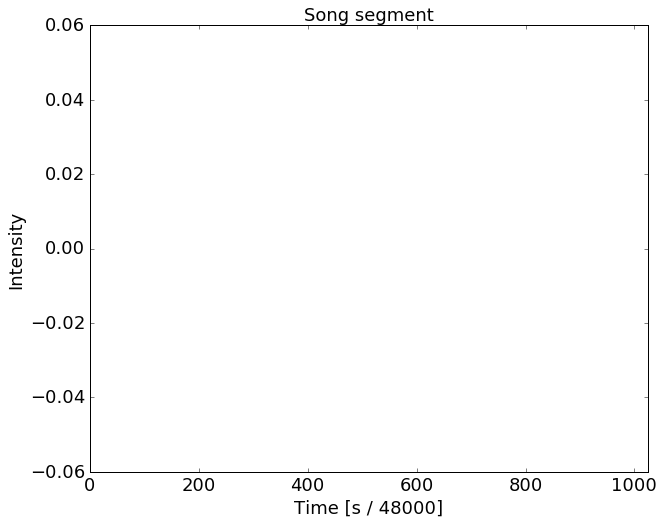

sample size:  0


In [119]:
song_segment = song_array1[48000*t_start:48000*t_start+segment_len]
fig1 = plt.figure(figsize=(10, 8), facecolor='white')
plt.plot(song_segment)
plt.xlabel('Time [s / 48000]', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.title('Song segment', fontsize=18)
axes = plt.gca()
axes.set_xlim([0, segment_len])
plt.show()
print('sample size: ',song_segment.size)

Our goal is to apply the FFT to this signal but we can see that even a sample segment does not look periodic

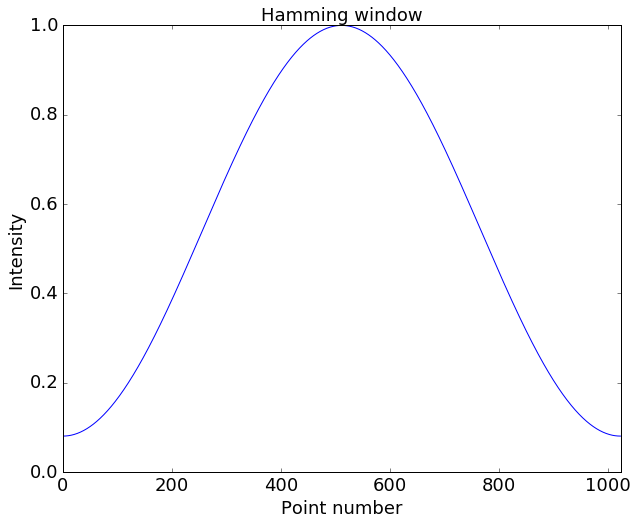

In [67]:
window = signal.hamming(segment_len)
fig2 = plt.figure(figsize=(10, 8), facecolor='white')
plt.plot(window)
plt.xlabel('Point number', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.title('Hamming window', fontsize=18)
axes = plt.gca()
axes.set_xlim([0, segment_len])
plt.show()

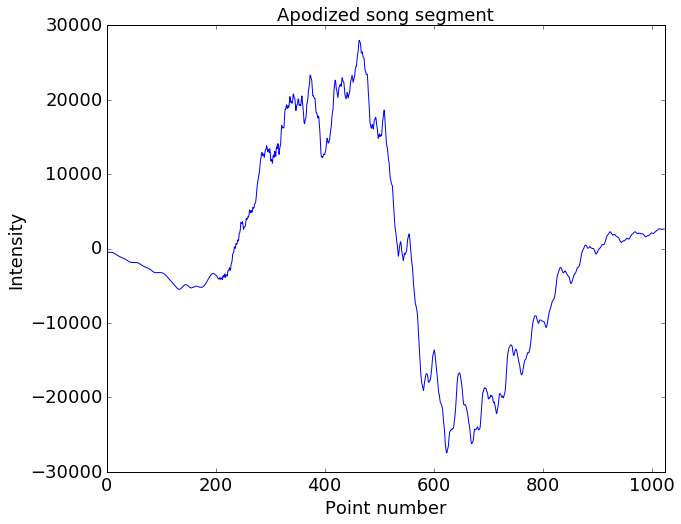

In [68]:
fig3 = plt.figure(figsize=(10, 8), facecolor='white')
plt.plot(window*song_segment)
plt.xlabel('Point number', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.title('Apodized song segment', fontsize=18)
axes = plt.gca()
axes.set_xlim([0, segment_len])
plt.show()

When hamming windows overlap they equal 1

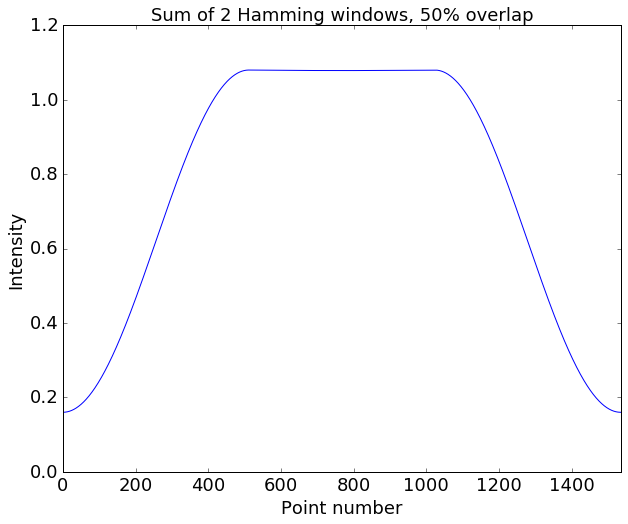

In [69]:
pad_len = int(segment_len/2)
window_pad = np.ones((pad_len,)) * window.min()

window_hamming_50ol = np.hstack((window_pad, window)) + np.hstack((window, window_pad))
fig4 = plt.figure(figsize=(10, 8), facecolor='white')
plt.plot(window_hamming_50ol)
plt.xlabel('Point number', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.title('Sum of 2 Hamming windows, 50% overlap', fontsize=18)
axes = plt.gca()
axes.set_xlim([0, len(window_hamming_50ol)])
plt.show()

#### We can now look at the sample audio file but zoom in closer till it looks roughly periodic

In [70]:
t_start=2;
segment_len = 1024;

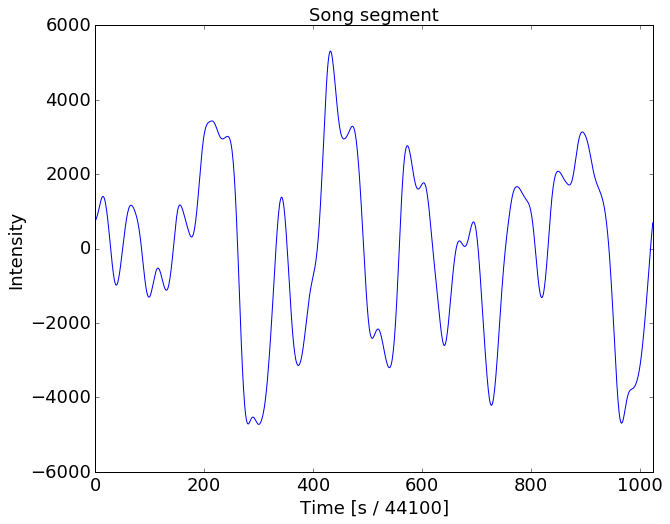

sample size:  1024


In [71]:
song_segment = song_array1[44000*t_start:44000*(t_start)+segment_len]
fig1 = plt.figure(figsize=(10, 8), facecolor='white')
plt.plot(song_segment)
plt.xlabel('Time [s / 44100]', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.title('Song segment', fontsize=18)
axes = plt.gca()
axes.set_xlim([0, segment_len])
plt.show()
print('sample size: ',song_segment.size)

Now we apply a hanning window with 50% overlap

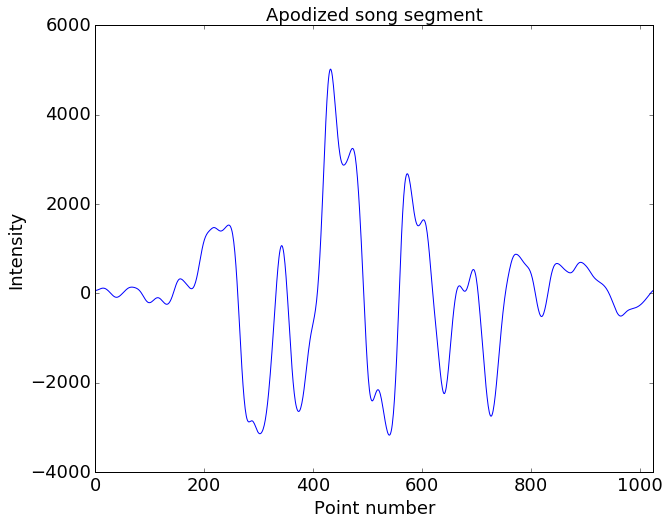

looks roughly periodic and will generate a good FFT


In [72]:
fig3 = plt.figure(figsize=(10, 8), facecolor='white')
plt.plot(window*song_segment)
plt.xlabel('Point number', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.title('Apodized song segment', fontsize=18)
axes = plt.gca()
axes.set_xlim([0, segment_len])
plt.show()
print('looks roughly periodic and will generate a good FFT')

# Begin to look at spectrum of a wav file
> matplotlib.pyplot.specgram(x, NFFT=None, Fs=None, Fc=None, detrend=None, window=None, noverlap=None, cmap=None, xextent=None, pad_to=None, sides=None, scale_by_freq=None, mode=None, scale=None, vmin=None, vmax=None, hold=None, data=None, **kwargs)

1. load in data array.
2. FFT should be the length of our sample which is limited by the nyquist rate to $ \dfrac{F_s}{2} $ .
3. overlap the windows which by defalt to hamming .
4. remove 0s from the fourier decomp so no errors using log(spec1)

In [120]:
spec1, freqs1, t1 = specgram(song_array1, NFFT=1024, Fs=rate1, noverlap=512, pad_to = None)
spec1[spec1 == 0] = 1e-6

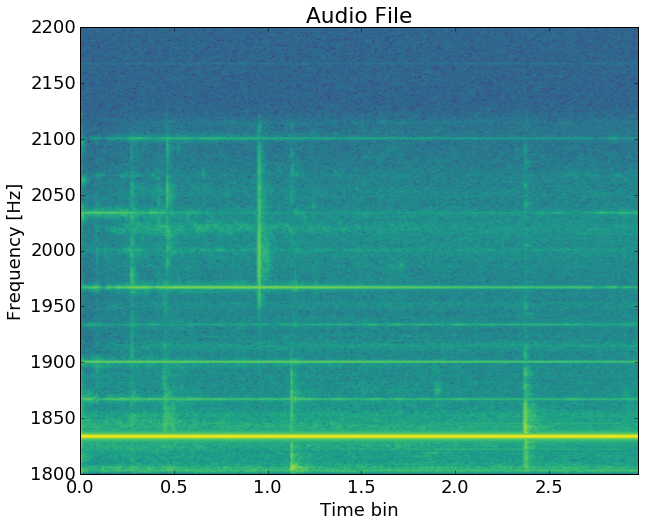

In [125]:
fig1 = plt.figure(figsize=(10, 8), facecolor='white')
#set image bounds 20 - 22 KHz
extent = 0, np.amax(t1), 1800, 2200

Z = 20.0 * np.log10(spec1) #possibly 20

Z = np.flipud(Z)

plt.imshow(Z, cmap='viridis', extent=extent)

#could use origin = 'lower' and then remove np.flipud(Z)
#imshow uses (0,0) in upper left corner, row/column fliped

plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Audio File')
plt.axis('auto')

ax = plt.gca()
ax.set_xlim([0, extent[1]])
ax.set_ylim(1800, 2200)
plt.show()

In [126]:
freqs1[0], freqs1[-1] 
#lowest and highest frequency

(0.0, 24000.0)

In [85]:
def cut_specgram(min_freq, max_freq, spec, freqs):
    
    #returns magnitude of spectrum values between 0-15KHz
    spec_cut = spec[(freqs >= min_freq) & (freqs <= max_freq)]
   
    #returns frequency between 0-15KHz
    freqs_cut = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
    
    #create a box around the magnitudes 
    Z_cut = 10 * np.log10(spec_cut)
    
    #flip the array since imshow (0,0) is upper left
    Z_cut = np.flipud(Z_cut)
    return Z_cut, freqs_cut


In [86]:
def show_peaks(Z, freqs, t, coord, title):
    fig = plt.figure(figsize=(10, 8), facecolor='white')
    #spec
    plt.imshow(Z, cmap='viridis')
    #peaks
    plt.scatter(coord[:, 1], coord[:, 0])
    #get current axis plots over current axis
    ax = plt.gca()
    
    #axis settings
    plt.xlabel('Time bin')
    plt.ylabel('Frequency')
    plt.title(title, fontsize=18)
    plt.axis('auto')
    ax.set_xlim([0, len(t)])
    ax.set_ylim([len(freqs), 0])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
   
    plt.show()

In [87]:
#set up your range for frequency
min_freq = 0
max_freq = 15000
#pass range, specrum data, and frequency data

Z1, freqs1 = cut_specgram(min_freq, max_freq, spec1, freqs1)

In [105]:
#coordinates is the indices of peaks
coordinates1 = peak_local_max(Z1, min_distance=20, threshold_abs=20)
coordinates1.dtype

dtype('int64')

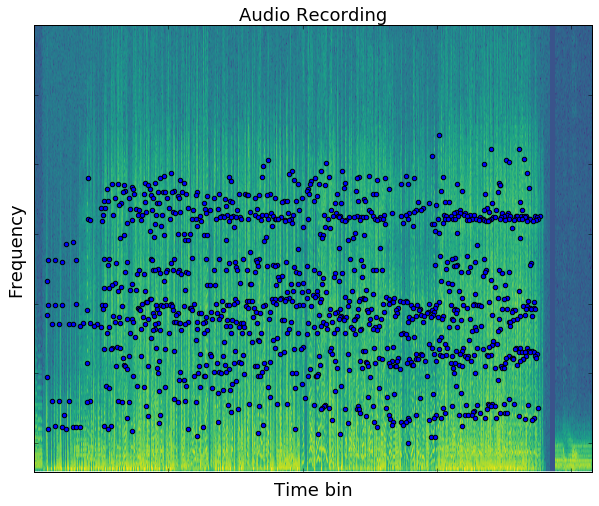

In [97]:
#2 plots overlayed on same axis (Z1, freqs1) and (t1, coordinates1)
show_peaks(Z1, freqs1, t1, coordinates1, 'Audio Recording')

In [76]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max

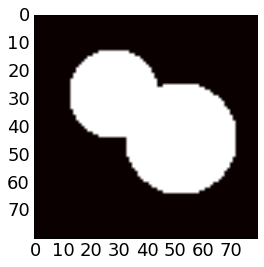

In [81]:
# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.logical_or(mask_circle1, mask_circle2)
plt.imshow(image,cmap = 'hot')

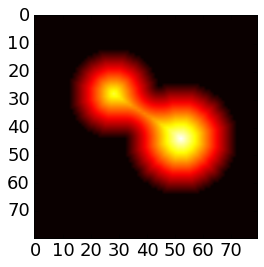

In [78]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage

distance = ndimage.distance_transform_edt(image)
plt.imshow(distance,cmap = 'hot')


local_maxi = peak_local_max(distance, min_distance = 10, threshold_abs = 10)

In [79]:
distance.dtype, distance.ndim

(dtype('float64'), 2)

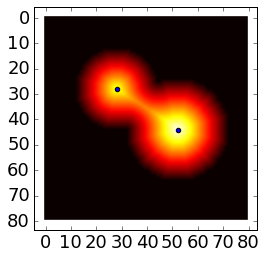

In [84]:
plt.figure()
plt.imshow(distance, cmap = 'hot')
plt.scatter(local_maxi[:, 1], local_maxi[:, 0])
plt.show()